# 🌀 Diffusion Models

Diffusion models can be considered hierarchicals VAE without a learned encoder

## 🎯 Motivation: Generating High-Quality Images

Diffusion models are a powerful class of **generative models** that can produce stunningly realistic images. They do this by learning how to **gradually denoise** random noise into data — in contrast to VAEs or GANs which directly output samples in one step.

---

## 🌫️ Forward Process: Diffusion

We define a **forward (noising) process** $q(x_{1:T} \mid x_0)$ that gradually adds Gaussian noise to a data sample $x_0$ over $T$ discrete time steps.

This process forms a **Markov chain** — each noisy sample $x_t$ depends **only on** the previous step $x_{t-1}$:

$$
q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} \, x_{t-1}, \beta_t \mathbf{I})
$$

Where:

- $x_0$ is the original data sample
- $\beta_1, \dots, \beta_T$ is a fixed noise schedule
- As $t \to T$, $x_t$ becomes increasingly noisy and approaches pure Gaussian noise

> **About $\beta_t$**: Each $\beta_t$ controls how much **variance** is added at step $t$. Equivalently, we can define $\alpha_t = 1 - \beta_t$. Then, for each step:
>
> $$
> x_t = \sqrt{\alpha_t}\,x_{t-1} \;+\; \sqrt{1 - \alpha_t}\,\epsilon_t,
> $$
>
> where $\epsilon_t \sim \mathcal{N}(0,\mathbf{I})$. This $\beta$-based schedule allows direct control of the **amount of noise** injected each step.

The full joint distribution over the diffusion trajectory is:

$$
q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1})
$$

Because this is a **Markov process**, we don’t need to condition on the entire history — just the immediate predecessor.

---

## 🏎 Beta Schedules: Linear vs. Cosine

### Linear Beta Scheduling

- **Linear**: We simply pick $\beta_t$ to increase linearly from $\beta_{\text{start}}$ to $\beta_{\text{end}}$.
- For example, $$\beta_t = \beta_{\text{start}} + t \cdot \frac{(\beta_{\text{end}} - \beta_{\text{start}})}{T-1}.$$
- **Pros**: Simple and easy to tune.
- **Cons**: Often adds too little noise in early steps and too much in later steps, sometimes causing less stable training or splotchy samples.

---

## 🔁 Reverse Process: Generative Modeling

To generate data, we define a **reverse-time Markov chain**:

$$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \mid x_t)
$$

Here:

- $p(x_T) = \mathcal{N}(0, \mathbf{I})$ is the starting point — pure Gaussian noise
- $p_\theta(x_{t-1} \mid x_t)$ is a learnable Gaussian distribution, parameterized by a neural network

Just like the forward process, this reverse chain is **Markovian**. Each step only depends on the current state $x_t$, not the entire history

This Markov structure simplifies the generative modeling process: we only need to learn how to take one step back in time, many times in a row.

Ideally, the learned reverse process $p_\theta(x_{t-1} \mid x_t)$ should match the true reverse conditionals $q(x_{t-1} \mid x_t, x_0)$ derived from the forward process.

---

## 📉 Variational Inference: ELBO Objective

Our ultimate goal is to model the **data distribution** $p_{\text{data}}(x_0)$ using a parameterized model $p_\theta(x_0)$. Ideally, we want to maximize:

$$
\log p_\theta(x_0)
$$

However, in a **latent variable model** like diffusion (or VAEs), $x_0$ is generated via **intermediate latent variables** — in this case, the noised versions $x_1, x_2, ..., x_T$.

So the marginal likelihood becomes:

$$
\log p_\theta(x_0) = \log \int p_\theta(x_0, x_1, ..., x_T) \, dx_{1:T}
= \log \int p_\theta(x_{0:T}) \, dx_{1:T}
$$

This integral is **intractable** because:

- $p_\theta(x_{t-1} \mid x_t)$ is parameterized by a neural network
- The latent space is high-dimensional (a trajectory over $T$ steps)

---

### 💡 Variational Trick: Importance Sampling

To deal with this, we apply **importance sampling**: introduce a known, tractable distribution $q(x_{1:T} \mid x_0)$ (the **forward diffusion process**) and rewrite the integral:

$$
\log p_\theta(x_0)
= \log \int \frac{q(x_{1:T} \mid x_0)}{q(x_{1:T} \mid x_0)} \, p_\theta(x_{0:T}) \, dx_{1:T}
= \log \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
$$

This is **exact** — we haven't approximated anything yet.

---

### ✅ Now Comes the Inequality: Jensen’s Inequality

The log of an expectation is **not equal to** the expectation of a log. In fact, by **Jensen’s inequality**, we have:

$$
\log \mathbb{E}_{q} \left[ f(x) \right] \geq \mathbb{E}_{q} \left[ \log f(x) \right]
$$

So applying this to our case:

$$
\log p_\theta(x_0)
= \log \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
\geq \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \log \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
$$

This **lower bound** is called the **Evidence Lower Bound (ELBO)**:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_{1:T} \mid x_0)} \left[
\log p_\theta(x_{0:T}) - \log q(x_{1:T} \mid x_0)
\right]
$$

---

### 📌 Intuition

- We're approximating the true (intractable) marginal likelihood with a **lower bound** that we can **actually compute and optimize**.
- The closer $q(x_{1:T} \mid x_0)$ is to the true posterior $p_\theta(x_{1:T} \mid x_0)$, the **tighter** the bound.
- In VAEs, $q$ is learned. In diffusion, it’s **fixed** and designed — but still works because we structure it well (Gaussian forward steps).

---

## 🔁 Modeling the Joint Distributions

Let’s expand both terms:

### 🔹 Reverse (Generative) Process:

We define the joint generative distribution as:

$$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \mid x_t)
$$

Where:

- $p(x_T)$ is the standard Gaussian prior
- $p_\theta(x_{t-1} \mid x_t)$ is modeled as a Gaussian parameterized by a neural net

### 🔹 Forward (Variational) Process:

The forward process (used for inference) is fixed and Markovian:

$$
q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1})
$$

---

## 🧮 ELBO Breakdown

Plug in the joint expressions for the **generative** and **forward** chains:

$$
\mathcal{L}_{\text{ELBO}}
= \mathbb{E}_{q(x_{1:T}\mid x_0)}\!
  \Bigg[
     \log p(x_T)
     + \sum_{t=1}^T \log p_\theta(x_{t-1}\mid x_t)
     - \sum_{t=1}^T \log q(x_t\mid x_{t-1})
  \Bigg].
$$

Isolate the $t=1$ terms:

$$
\mathcal{L}_{\text{ELBO}}
= \mathbb{E}_{q}\!
  \Big[
      \log p(x_T)
      - \log q(x_1\mid x_0)
      + \log p_\theta(x_0\mid x_1)
      + \sum_{t=2}^T
        \bigl(
            \log p_\theta(x_{t-1}\mid x_t)
          - \log q(x_t\mid x_{t-1})
        \bigr)
  \Big].
$$

Because every distribution in the chain is Gaussian, each bracket can be rewritten in **closed form** as a KL divergence.  
For $t\ge2$ we obtain the _true_ reverse posterior via **Bayes’ rule**:

$$
q(x_{t-1}\mid x_t,x_0)
\propto q(x_t\mid x_{t-1}) \; q(x_{t-1}\mid x_0),
$$

which is again Gaussian. Substituting yields the tidy KL decomposition for the ELBO (Evidence Lower Bound), which we aim to maximize:

$$
\boxed{
\mathcal{L}_{\text{ELBO}}
= \mathbb{E}_{q(x_1\mid x_0)} \bigl[\log p_\theta(x_0\mid x_1)\bigr]
  - \sum_{t=2}^{T}
      \mathbb{E}_{q(x_t,x_{t-1}\mid x_0)}
      \Bigl[
        D_{\text{KL}}\!\bigl(q(x_{t-1}\mid x_t,x_0)\,\|\,p_\theta(x_{t-1}\mid x_t)\bigr)
      \Bigr]
  - D_{\text{KL}}\!\bigl(q(x_T\mid x_0)\,\|\,p(x_T)\bigr).
}
$$

We want to maximize this $\mathcal{L}_{\text{ELBO}}$, just like we maximize the ELBO in VAE training.

### 🪄 Step-by-Step: Rewriting Each Term

#### ✅ Step 1: Prior Matching Term

Start with the first term from the ELBO in log-form:

$$
\mathbb{E}_{q(x_{1:T} \mid x_0)} [\log p(x_T)]
= \mathbb{E}_{q(x_T \mid x_0)} [\log p(x_T)]
$$

Now, add and subtract $\log q(x_T \mid x_0)$ inside the expectation:

$$
= \mathbb{E}_{q(x_T \mid x_0)} \left[
\log p(x_T) - \log q(x_T \mid x_0)
+ \log q(x_T \mid x_0)
\right]
$$

This gives:

$$
= -D_{\text{KL}}(q(x_T \mid x_0) \,\|\, p(x_T)) + \mathcal{H}(q(x_T \mid x_0))
$$

Since the entropy term $\mathcal{H}(q)$ does **not** depend on the model parameters $\theta$, we can ignore it for optimization.  
So the main optimization-relevant term is:

$$
-D_{\text{KL}}(q(x_T \mid x_0) \,\|\, p(x_T))
$$

---

#### ✅ Step 2: Reverse KLs ($t = 2, \dots, T$)

The terms in the ELBO sum for $t=2, \dots, T$ are of the form:
$$ \mathbb{E}_{q(x_{1:T}\mid x_0)} \left[ \log p_\theta(x_{t-1}\mid x_t) - \log q(x_t\mid x_{t-1}) \right] $$
Due to the Markov properties, the expectation relevant for a specific $t$ simplifies to $\mathbb{E}_{q(x_t, x_{t-1}\mid x_0)}$. So we analyze:
$$ \mathcal{L}_{t}' = \mathbb{E}_{q(x_t, x_{t-1}\mid x_0)} \left[ \log p_\theta(x_{t-1}\mid x_t) - \log q(x_t\mid x_{t-1}) \right] $$
We want to relate this to a KL divergence involving $q(x_{t-1} \mid x_t, x_0)$ (the true posterior) and $p_\theta(x_{t-1} \mid x_t)$ (the model's reverse step).
We use Bayes' rule for the true posterior:
$$ q(x_{t-1} \mid x_t, x_0) = \frac{q(x_t \mid x_{t-1}, x_0) q(x_{t-1} \mid x_0)}{q(x_t \mid x_0)} $$
Since the forward process $q(x_t \mid x_{t-1})$ is Markovian and independent of $x_0$ given $x_{t-1}$, $q(x_t \mid x_{t-1}, x_0) = q(x_t \mid x_{t-1})$. So,
$$ q(x_{t-1} \mid x_t, x_0) = \frac{q(x_t \mid x_{t-1}) q(x_{t-1} \mid x_0)}{q(x_t \mid x_0)} $$
Rearranging this gives an expression for $\log q(x_t \mid x_{t-1})$:
$$ \log q(x_t \mid x_{t-1}) = \log q(x_{t-1} \mid x_t, x_0) + \log q(x_t \mid x_0) - \log q(x_{t-1} \mid x_0) $$
Substitute this into the expression for $\mathcal{L}_{t}'$:
$$ \mathcal{L}_{t}' = \mathbb{E}_{q(x_t, x_{t-1}\mid x_0)} \left[ \log p_\theta(x_{t-1}\mid x_t) - \left( \log q(x_{t-1} \mid x_t, x_0) + \log \frac{q(x_t \mid x_0)}{q(x_{t-1} \mid x_0)} \right) \right] $$
$$ \mathcal{L}_{t}' = \mathbb{E}_{q(x_t, x_{t-1}\mid x_0)} \left[ \log \frac{p_\theta(x_{t-1}\mid x_t)}{q(x_{t-1} \mid x_t, x_0)} \right] - \mathbb{E}_{q(x_t, x_{t-1}\mid x_0)} \left[ \log \frac{q(x_t \mid x_0)}{q(x_{t-1} \mid x_0)} \right] $$
The first term is, by definition of KL divergence:
$$ \mathbb{E}_{q(x_t|x_0)} \left[ \mathbb{E}_{q(x_{t-1}|x_t,x_0)} \left[ \log \frac{p_\theta(x_{t-1}\mid x_t)}{q(x_{t-1} \mid x_t, x_0)} \right] \right] = - \mathbb{E}_{q(x_t|x_0)} \left[ D_{\text{KL}}(q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t)) \right] $$
The expectation $\mathbb{E}_{q(x_t|x_0)}$ can also be written as $\mathbb{E}_{q(x_t,x_{t-1}\mid x_0)}$ since the $D_{KL}$ term is already an expectation over $x_{t-1}$ conditioned on $x_t, x_0$.


The second term, $- \mathbb{E}_{q(x_t, x_{t-1}\mid x_0)} \left[ \log \frac{q(x_t \mid x_0)}{q(x_{t-1} \mid x_0)} \right]$, expands to $- \left( \mathbb{E}_{q(x_t\mid x_0)}[\log q(x_t \mid x_0)] - \mathbb{E}_{q(x_{t-1}\mid x_0)}[\log q(x_{t-1} \mid x_0)] \right)$. This is a difference of entropies $H(q(x_t \mid x_0)) - H(q(x_{t-1} \mid x_0))$, which does not depend on the model parameters $\theta$ and can be ignored during optimization.
Thus, the contribution of these terms to the ELBO (up to constants) is:
$$ - D_{\text{KL}}(q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t)) $$
When summed over $t=2, \dots, T$ and including the outer expectation $\mathbb{E}_{q(x_t,x_{t-1}\mid x_0)}$ (or more broadly $\mathbb{E}_{q(x_1,\dots,x_T \mid x_0)}$), these form the reverse KL terms in the final ELBO expression.
The expectation for the KL divergence term is often written as $\mathbb{E}_{q(x_t, x_{t-1} \mid x_0)}$ as it appears in the final ELBO formula.

---

#### ✅ Step 3: Reconstruction Term ($t = 1$)

From the ELBO:

$$
-\log q(x_1 \mid x_0) + \log p_\theta(x_0 \mid x_1)
$$

This part doesn’t convert into a KL divergence because $q(x_1 \mid x_0)$ is fixed (we're not learning it).  
So we just leave this term as a direct expectation:

$$
\mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]
$$

## ✅ Final Variational Loss (Full DDPM Objective)

Bringing it all together, the Evidence Lower Bound (ELBO) to be maximized is:

$$
\mathcal{L}_{\text{ELBO}} =
\underbrace{\mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]}_{\text{Reconstruction}}
- \sum_{t=2}^T\mathbb{E}_{q(x_t,x_{t-1}\mid x_0)}
\underbrace{D_{\text{KL}}(q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t))}_{\text{Reverse KLs}}
- \underbrace{D_{\text{KL}}(q(x_T \mid x_0) \,\|\, p(x_T))}_{\text{Prior term}}
$$


This $\mathcal{L}_{\text{ELBO}}$ is a true variational lower bound on $\log p_\theta(x_0)$ and is maximized during training.

The diffusion loss, $\mathcal{L}_{\text{diffusion}}$, which is minimized in practice, is defined as $-\mathcal{L}_{\text{ELBO}}$:
$$
\mathcal{L}_{\text{diffusion}} = -\mathcal{L}_{\text{ELBO}} =
-\underbrace{\mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]}_{\text{Negative Reconstruction}}
+ \sum_{t=2}^T\mathbb{E}_{q(x_t,x_{t-1}\mid x_0)}
\underbrace{D_{\text{KL}}(q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t))}_{\text{Reverse KLs}}
+ \underbrace{D_{\text{KL}}(q(x_T \mid x_0) \,\|\, p(x_T))}_{\text{Prior term}}
$$
Minimizing $\mathcal{L}_{\text{diffusion}}$ is thus equivalent to maximizing $\mathcal{L}_{\text{ELBO}}$.

---

## ✂️ Simplifying the ELBO: From Variational Bound to Noise Prediction

In practice, diffusion models are trained using a **much simpler objective** than the full ELBO derived earlier. This section explains why that's valid and how it works.

---

### 🔁 Recall: The Full ELBO

The **reverse KL terms** at each timestep measure how well the learned reverse distribution $p_\theta(x_{t-1} \mid x_t)$ matches the true reverse posterior $q(x_{t-1} \mid x_t, x_0)$. The reconstruction term aims to accurately reconstruct $x_0$ from $x_1$.

---

### 🧠 Insight: KL Between Gaussians Has a Closed Form

All distributions involved are Gaussian, so we can compute the KL divergence analytically.

### 🔍 Why Focus Only on Reverse KLs?

When simplifying the ELBO, we primarily focus on the reverse KL terms while the reconstruction term and prior term receive less emphasis. Here's why:

#### Prior Term
- **Vanishes with Large $T$**: As $T$ increases, $q(x_T|x_0) \approx \mathcal{N}(0,I) \approx p(x_T)$, making the KL term negligible.
- **Fixed by Design**: The forward process is specifically designed so that $x_T$ is nearly pure Gaussian noise when $T$ is sufficiently large.
- **Not Trainable**: This term doesn't depend on model parameters $\theta$ when the diffusion process is fixed.

#### Reconstruction Term ($t=1$)
- **Uniform Sampling**: In practice, we sample time steps $t$ uniformly during training, so $t=1$ is just one of many steps.
- **Implicit Handling**: The model learns to predict noise at all time steps, including $t=1$, so this reconstruction is implicitly handled through the same mechanism.
- **Variance Considerations**: The $t=1$ term has higher variance and can be more challenging to optimize directly.

#### Reverse KLs ($t=2,...,T$)
- **Core of Learning**: These terms directly guide learning the denoising process.
- **Simplifiable**: Can be reformulated into the simpler noise prediction objective.
- **Sufficient**: Optimizing these terms is sufficient for high-quality generation.

Specifically, for each $t \geq 1$, the true posterior is:

$$
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}\left(x_{t-1}; \mu_q(x_t, x_0), \Sigma_q(t)\right)
$$

We approximate it with:

$$
p_\theta(x_{t-1} \mid x_t) = \mathcal{N}\left(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(t)\right)
$$

To minimize the KL divergence between these two Gaussians, we only need to match their **means** (since variances are fixed or learned separately). So:

> Training reduces to minimizing the squared error between the true posterior mean $\mu_q(x_t, x_0)$ and the predicted mean $\mu_\theta(x_t, t)$.

---

### 🧩 Expressing the True Mean $\mu_q$ in Terms of Noise $\epsilon$

The goal of the diffusion model's training objective is to approximate the **true reverse distribution**:

$$
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}(x_{t-1}; \mu_q(x_t, x_0), \Sigma_q(t))
$$

The model defines a learned reverse process:

$$
p_\theta(x_{t-1} \mid x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(t))
$$

Our objective is to minimize the KL divergence between these Gaussians. When variances are fixed or matched, this reduces to minimizing the squared error between their means:

$$
D_{\text{KL}}(q \,\|\, p_\theta) \propto \left\| \mu_q(x_t, x_0) - \mu_\theta(x_t, t) \right\|^2
$$

#### 🔄 Forward Process Recap

In the forward (noising) process, we have:

$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon,
\quad \epsilon \sim \mathcal{N}(0, \mathbf{I})
$$

Solving for $x_0$, we get:

$$
x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1 - \bar{\alpha}_t} \, \epsilon \right)
$$

#### 🧠 Plugging into the Reverse Mean

From DDPM derivations, the true reverse posterior mean has a closed-form expression:

$$
\mu_q(x_t, x_0) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \epsilon \right)
$$

This shows that the mean $\mu_q$ is a **linear function of $x_t$ and the original noise $\epsilon$**.

#### 🎯 Why Predict Noise Instead of Mean?

This formulation is key: if we can estimate $\epsilon$, we can plug it into the expression above to get $\mu_q$. So instead of learning to predict the mean $\mu_q(x_t, x_0)$ directly, we define the model to predict noise:

$$
\hat{\epsilon} = \epsilon_\theta(x_t, t)
$$

Then plug it in to form:

$$
\hat{\mu}_q = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \hat{\epsilon} \right)
$$

Thus, minimizing the squared error between $\mu_q$ and $\hat{\mu}_q$ is equivalent to minimizing:

$$
\left\| \epsilon - \epsilon_\theta(x_t, t) \right\|^2
$$

---

### 🧪 Final Training Objective as Expectation

We aim to train a model $ \epsilon_\theta(x_t, t) $ that predicts the true noise $ \epsilon $ used in the forward noising process.

Given the forward process:
$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})
$$

We define the **full training objective** as a **nested expectation** over:

- Data distribution $ x_0 \sim p_{\text{data}} $
- Timestep $ t \sim \text{Uniform}(\{1, \dots, T\}) $
- Noise $ \epsilon \sim \mathcal{N}(0, \mathbf{I}) $

$$
\boxed{
\mathcal{L}_{\text{diffusion}} =
\mathbb{E}_{x_0 \sim p_{\text{data}}} \;
\mathbb{E}_{t \sim \text{Uniform}(1, T)} \;
\mathbb{E}_{\epsilon \sim \mathcal{N}(0, I)} \left[
\left\| \epsilon - \epsilon_\theta\left(x_t, t\right) \right\|^2
\right]
}
$$

where:

$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon
$$

---

### 🧩 Interpretation

This expectation formulation means:

- You’re sampling **true data** $ x_0 $,
- Then choosing a **random timestep** $ t $,
- And generating a **noisy version** $ x_t $ using Gaussian noise $ \epsilon $,
- Then training the model to **predict that noise** from $ (x_t, t) $.

This is the standard **denoising score matching objective** used in DDPM training — a Monte Carlo approximation of this expectation is what actually happens in each training step.

---

### 🎨 How Noise Prediction is Used to Generate Images

Once the model is trained to predict noise, we can **generate images** by reversing the forward diffusion process step-by-step. Here's how this works in practice:

#### 1. Start from pure Gaussian noise:

We initialize the process with a random noise sample:
$$
x_T \sim \mathcal{N}(0, \mathbf{I})
$$

#### 2. Iteratively denoise from $T \to 1$:

For each timestep $t = T, T-1, \dots, 1$:

1. Predict the noise that was added at this step:
   $$
   \hat{\epsilon} = \epsilon_\theta(x_t, t)
   $$

2. Use this noise prediction to compute the **posterior mean** of the reverse process:
   $$
   \mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(
   x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \hat{\epsilon}
   \right)
   $$

3. Sample the next image in the reverse trajectory:
   $$
   x_{t-1} \sim \mathcal{N}(\mu_\theta(x_t, t), \sigma_t^2 \mathbf{I})
   $$
   where the variance $\sigma_t^2$ is derived from the beta schedule.

This loop is repeated until we reach $x_0$, the final generated image.

#### 3. Postprocessing:

The generated sample $x_0$ lies in the range \([-1, 1]\) due to the training normalization. It is rescaled to \([0, 1]\) for visualization:
$$
x_0 \leftarrow \frac{x_0 + 1}{2}
$$

---

In summary:  
> The model learns to **predict the noise** at each timestep. During generation, we **subtract this noise** in a controlled way to denoise the image, step-by-step, from pure Gaussian noise into a high-quality sample.

---

## ✅ Summary

- We use the forward process to generate training pairs $(x_t, \epsilon)$.
- The model learns to **predict $\epsilon$** from $(x_t, t)$.
- Once trained, we can **start from noise** and **denoise step-by-step** using the predicted $\epsilon$.
- The process is grounded in a **true probabilistic model** and the noise prediction is equivalent (up to constants) to maximizing the variational lower bound.

## References

- [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)
- [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672)


# 🚀 Extended Explanation of the Code: DDPM Implementation Details

Below is a **supplement** to the earlier diffusion discussion. It explains the **key components** in the provided Denoising Diffusion Probabilistic Model (DDPM) code, such as the **UNet with Time Conditioning**, the **`MNISTDiffusion` class encapsulating the DDPM logic**, and **training specifics**. U-Net is used in diffusion models because its skip connections allow the model to preserve fine-grained spatial details from the input noisy image while also capturing global context through the encoder-decoder structure, which is essential for accurately predicting the noise pattern that needs to be removed at each denoising step.

Since the U-Net architecture was already mentioned in [`02.vae-without-encoder.ipynb`](./02.vae-without-encoder.ipynb), here we'll mostly talk about how to inject time information, to the neural network.

---

## 1. **UNet with Time Conditioning**

The core of our diffusion model is a U-Net that predicts the noise $\epsilon$ added to an image $x_0$ at a given timestep $t$. Since the diffusion process progresses over time, the model needs to be aware of the current timestep when denoising. This is achieved through **time conditioning**.

There are many ways to inject time information into a neural network. Some models use learnable embeddings to modulate feature vectors dynamically. However, in our implementation, we use the **simplest and most widely adopted approach**: **fixed sinusoidal positional encodings**, originally proposed in the Transformer paper (_Attention Is All You Need_, 2017).

---

### 🧠 Sinusoidal Embeddings for Timesteps

We encode each timestep $t$ as a high-dimensional vector using sine and cosine functions at multiple frequencies:

$$
\text{PE}_{t,2i} = \sin\left(\frac{t}{10000^{2i/d}}\right), \quad
\text{PE}_{t,2i+1} = \cos\left(\frac{t}{10000^{2i/d}}\right)
$$

This encoding has several advantages:
- It is **parameter-free** (no learning needed)
- It encodes both **absolute** and **relative** time differences
- It enables **smooth interpolation** across timesteps

---

### 🧩 How Time is Injected into the UNet

1. The sinusoidal embedding vector $\mathbf{e}_t \in \mathbb{R}^{d}$ is computed for each timestep $t$.
2. This vector is reshaped and **added element-wise** to the feature maps $\mathbf{x}$ at various layers in the encoder and decoder:

    $$
    \mathbf{x} \;\leftarrow\; \phi(\mathbf{x} + \mathbf{e}_t), \quad \text{where } \phi \text{ is a non-linear function}
    $$


1. This simple addition informs the network of the current noise level without needing extra learnable parameters.

---

### 🏗️ UNet Structure Recap

- **Encoder**: Downsampling path with `EncoderBlock`s that contain residual layers and inject time using sinusoidal embeddings.
- **Middle**: Bottleneck with residual blocks.
- **Decoder**: Upsampling path with `DecoderBlock`s that concatenate skip connections and inject the same time embeddings.
- **Skip Connections**: Standard UNet-style skips help preserve spatial details.

By using sinusoidal embeddings, we reduce complexity while retaining the essential capability for temporal conditioning — particularly suitable for datasets like MNIST where heavy overparameterization isn't necessary.

---

## 2. **`MNISTDiffusion` Class: The Full DDPM Pipeline**

The `MNISTDiffusion` class implements the full denoising diffusion probabilistic model (DDPM) workflow — including both the **forward (noising)** process used for training and the **reverse (generative)** process used for sampling.

---

### 🔁 1. Noise Schedule (`_linear_variance_schedule`)

- Defines a smooth, monotonically increasing sequence of noise variances $\beta_t$ using a linear function.
- From $\beta_t$, we compute:
  - $\alpha_t = 1 - \beta_t$
  - $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$
- These values are used to control both the forward noising and reverse denoising processes.

---

### 🧪 2. Forward Process for Training (`forward`, `q_sample`)

During training, the model learns to **predict the noise** that was added to an image:

1. For each image $x_0$ in the batch:
   - Sample a random timestep $t \sim \text{Uniform}(1, T)$.
   - Generate a noisy image $x_t$:
     $$
     x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon,
     \quad \epsilon \sim \mathcal{N}(0, I)
     $$
   - This is done in the `q_sample(x0, t, noise)` function.

2. The model (`self.model`) then predicts the noise $\hat{\epsilon}_\theta(x_t, t)$.

3. Training minimizes the mean squared error:
   $$
   \mathcal{L}_{\text{train}} = \left\| \hat{\epsilon}_\theta(x_t, t) - \epsilon \right\|^2
   $$

---

### 🧨 3. Reverse Process for Sampling (`sample`, `p_sample`, `p_sample_clipped`)

Once trained, the model can generate new images starting from random noise:

1. **Initialization**:
   - Sample $x_T \sim \mathcal{N}(0, I)$

2. **Iterative Denoising** for $t = T, T-1, ..., 1$:
   - Predict the noise:
     $$
     \hat{\epsilon}_\theta(x_t, t)
     $$
   - Compute the mean of the reverse posterior:
     $$
     \mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(
     x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \hat{\epsilon}_\theta
     \right)
     $$
   - Sample $x_{t-1} \sim \mathcal{N}(\mu_\theta, \sigma_t^2 \mathbf{I})$
     - If `clipped=True`, `p_sample_clipped` clips $\hat{x}_0$ to $[-1, 1]$ before recomputing $\mu$ for improved stability.

3. The final output $x_0$ is rescaled from $[-1, 1]$ to $[0, 1]$ for image display.

---

### 🧠 Summary

- **Training**: Learn to predict the noise added at each timestep.
- **Generation**: Iteratively denoise starting from Gaussian noise using the learned noise predictor.
- **Time Conditioning**: Timestep $t$ is encoded using **fixed sinusoidal embeddings**.

This setup matches the original DDPM architecture while simplifying the time-conditioning mechanism for clarity and efficiency.

---

## 3. **Training Details**

*   **Data**: MNIST images are loaded and normalized to the range $[-1,1]$.
*   **Loss**: Mean Squared Error (MSE) between the true added noise $\epsilon$ and the U-Net's predicted noise $\hat{\epsilon}$.
    *   **Why MSE?**: As discussed in the theoretical sections, minimizing $\|\epsilon - \epsilon_\theta(x_t, t)\|^2$ is equivalent (up to weighting factors often ignored in simpler implementations) to optimizing the terms in the ELBO that involve matching the mean of the learned reverse distribution $p_\theta(x_{t-1}|x_t)$ to the mean of the true posterior $q(x_{t-1}|x_t, x_0)$.
*   **Optimization**: The Adam optimizer is used to update the U-Net's parameters.
*   **Logging**: Periodically, during training, the current loss is logged, and image samples are generated using the `sample` method to visually inspect progress.

---

## 4. **Putting It All Together**

1.  The code implements a **DDPM** for MNIST generation.
2.  Key components include:
    *   A **simple U-Net with standard convolutions** for noise prediction.
    *   **Time conditioning** to inform the U-Net about the current noise level $t$.
    *   A **cosine beta schedule** for a smooth noising process.
    *   **Clipping** of the predicted $\hat{x}_0$ during sampling to maintain valid pixel values.
3.  **Training Loop**:
    *   For each batch, sample random timesteps $t$.
    *   Noise images to $x_t$.
    *   Train the U-Net to predict the added noise $\epsilon$ using an MSE loss.
4.  **Sampling Loop**:
    *   Start from $x_T \sim \mathcal{N}(0,I)$.
    *   Iteratively apply the learned reverse (denoising) step, using the U-Net's noise prediction at each $t$, until $x_0$ is obtained.

This setup provides a fully functional, straightforward DDPM that incorporates common improvements found in modern diffusion model implementations.

---

## 🎉 **Conclusion**

*   The implemented pipeline is a standard **DDPM** enhanced with typical improvements like a **cosine beta schedule** and a **time-conditioned U-Net**.
*   The underlying mathematical framework aligns with the original **DDPM** paper, with the noise prediction objective being a practical simplification of the full variational bound.
*   The combination of simple architectural choices and proven training strategies leads to successful training and good quality image generation on datasets like MNIST, demonstrating the core concepts without unnecessary complexity.

You now have a comprehensive overview of how the simple code components fit together to realize a Denoising Diffusion Probabilistic Model. I really tried to use the most simple modules as possible, for the educational purposes. As you can imagine, there are so many improvements you can make, better U-net architecture, better noise scheduling, better time information injection, etc., but I thought adding them would over-complicate the code and hurt the learning purposes. Feel try to modify the code and see the improvements yourself! 

## References

- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
- [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)

In [1]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


def get_timestep_embedding(timesteps: torch.Tensor, channels: int, max_period: int = 10000):
    """Fixed sinusoidal timestep embeddings.

    Args:
        timesteps: (B,) integer tensor of timesteps
        channels:  dimension of the output embedding (== feature channels)
        max_period: controls the minimum frequency of the sinusoids
    Returns:
        Tensor of shape (B, channels) with sine & cosine positional encodings.
    """
    half_dim = channels // 2
    exponent = -math.log(max_period) * torch.arange(half_dim, device=timesteps.device).float() / half_dim
    emb = timesteps.float().unsqueeze(1) * torch.exp(exponent).unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if channels % 2 == 1:  # zero‑pad if channels is odd
        emb = torch.cat([emb, emb.new_zeros(emb.size(0), 1)], dim=1)
    return emb  # (B, channels)


class ConvBlock(nn.Module):
    """Simple residual block with regular convolutions"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class ResBlock(nn.Module):
    """Simple residual block with regular convolutions"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = ConvBlock(channels, channels)
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
        )
        self.act = nn.SiLU()

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + residual
        return self.act(x)


class DownBlock(nn.Module):
    """Downsample block"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class UpBlock(nn.Module):
    """Upsample block"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.up(x)
        return self.conv(x)


class EncoderBlock(nn.Module):
    """Encoder block with residual layers and downsampling"""

    def __init__(self, in_channels, out_channels, num_res_blocks=2):
        super().__init__()

        # Residual blocks at current resolution
        self.res_blocks = nn.ModuleList([ResBlock(in_channels) for _ in range(num_res_blocks)])

        # Downsample
        self.downsample = DownBlock(in_channels, out_channels)

    def forward(self, x, t):
        # residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)

        # Time conditioning
        emb = get_timestep_embedding(t, x.size(1)).view(x.size(0), x.size(1), 1, 1)
        x = nn.functional.silu(x + emb)

        # skip connection then downsample
        x_skip = x
        x = self.downsample(x)

        return x, x_skip


class DecoderBlock(nn.Module):
    """Decoder block with upsampling and residual layers"""

    def __init__(self, in_channels, out_channels, num_res_blocks=2):
        super().__init__()

        # Upsample
        self.upsample = UpBlock(in_channels, out_channels)

        # Residual blocks after concatenation (out_channels + skip_channels)
        self.res_blocks = nn.ModuleList([ResBlock(out_channels * 2) for _ in range(num_res_blocks)])

        # Final conv to reduce channels
        self.final_conv = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, x_skip, t):
        # Upsample
        x = self.upsample(x)

        # Concatenate with skip connection
        x = torch.cat([x, x_skip], dim=1)

        # Apply residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)

        # Time conditioning        
        emb = get_timestep_embedding(t, x.size(1)).view(x.size(0), x.size(1), 1, 1)
        x = nn.functional.silu(x + emb)

        # Final conv        
        x = self.final_conv(x)

        return x


class Unet(nn.Module):
    """UNet backbone for DDPM with fixed sinusoidal time embeddings."""

    def __init__(
        self,
        in_channels: int = 1,
        out_channels: int = 1,
        base_dim: int = 64,
        dim_mults=(2, 4),
        num_res_blocks_encoder: int = 2,
        num_res_blocks_decoder: int = 2,
        num_res_blocks_mid: int = 2,
    ):
        super().__init__()
        self.init_conv = ConvBlock(in_channels, base_dim)

        # compute channel dims for each resolution
        dims = [base_dim]
        for mult in dim_mults:
            dims.append(base_dim * mult)

        # encoder
        self.enc_blocks = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.enc_blocks.append(
                EncoderBlock(
                    in_channels=dims[i],
                    out_channels=dims[i + 1],
                    num_res_blocks=num_res_blocks_encoder,
                )
            )

        # middle
        mid_dim = dims[-1]
        self.mid_blocks = nn.ModuleList([ResBlock(mid_dim) for _ in range(num_res_blocks_mid)])

        # decoder
        self.dec_blocks = nn.ModuleList()
        for i in range(len(dims) - 1, 0, -1):
            self.dec_blocks.append(
                DecoderBlock(
                    in_channels=dims[i],
                    out_channels=dims[i - 1],
                    num_res_blocks=num_res_blocks_decoder,
                )
            )

        self.final_conv = nn.Conv2d(base_dim, out_channels, 1)

    def forward(self, x, t):
        """Forward pass through the UNet.

        Args:
            x: Input tensor of shape (B, C, H, W)
            t: Tensor of integer timesteps of shape (B,)
        """
        # Initial conv
        x = self.init_conv(x)

        # Encoder path        
        skips = []
        for enc_block in self.enc_blocks:
            x, x_skip = enc_block(x, t)
            skips.append(x_skip)

        # Middle blocks
        for mid_block in self.mid_blocks:
            x = mid_block(x)

        # Decoder path
        skips.reverse()
        for dec_block, x_skip in zip(self.dec_blocks, skips):
            x = dec_block(x, x_skip, t)

        # Final conv
        return self.final_conv(x)


class MNISTDiffusion(nn.Module):
    def __init__(
        self,
        image_size: int = 28,
        in_channels: int = 1,
        timesteps: int = 1000,
        base_dim: int = 64,
        dim_mults=(2, 4),
        num_res_blocks_encoder: int = 2,
        num_res_blocks_decoder: int = 2,
        num_res_blocks_mid: int = 2,
    ):
        super().__init__()
        self.timesteps = timesteps
        self.in_channels = in_channels
        self.image_size = image_size

        betas = self._linear_variance_schedule(timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=-1)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )

        self.model = Unet(
            in_channels=in_channels,
            out_channels=in_channels,
            base_dim=base_dim,
            dim_mults=dim_mults,
            num_res_blocks_encoder=num_res_blocks_encoder,
            num_res_blocks_decoder=num_res_blocks_decoder,
            num_res_blocks_mid=num_res_blocks_mid,
        )

    @staticmethod
    def _linear_variance_schedule(t, beta_start=1e-4, beta_end=0.02):
        """β_t linearly spaced from beta_start to beta_end."""
        return torch.linspace(beta_start, beta_end, t, dtype=torch.float32)

    # --------------------------------------------------
    # forward pass (training)
    # --------------------------------------------------
    def forward(self, x, noise):
        B = x.size(0)
        t = torch.randint(0, self.timesteps, (B,), device=x.device)
        x_t = self.q_sample(x, t, noise)
        pred_noise = self.model(x_t, t)
        return pred_noise

    # --------------------------------------------------
    # helper: forward diffusion q(x_t | x_0)
    # --------------------------------------------------
    def q_sample(self, x0, t, noise):
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_t * noise

    # --------------------------------------------------
    # reverse process sampling
    # --------------------------------------------------
    @torch.no_grad()
    def p_sample(self, x_t, t, noise):
        # Predict noise added to x_t at timestep t
        pred = self.model(x_t, t)

        # Get alpha_t, beta_t, and their cumulative values
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_cum_t = self.alphas_cumprod[t].view(-1, 1, 1, 1)
        beta_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_cum_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

        # This version directly computes mean of p(x_{t-1} | x_t)
        # using the predicted noise, without reconstructing x_0.
        mean = (1.0 / torch.sqrt(alpha_t)) * (x_t - ((1.0 - alpha_t) / sqrt_one_minus_cum_t) * pred)

        # Posterior variance
        if t.min() > 0:
            alpha_cum_prev = self.alphas_cumprod[(t - 1).clamp_min(0)].view(-1, 1, 1, 1)
            std = torch.sqrt(beta_t * (1.0 - alpha_cum_prev) / (1.0 - alpha_cum_t))
        else:
            std = 0.0

        return mean + std * noise


    @torch.no_grad()
    def p_sample_clipped(self, x_t, t, noise):
        # Predict noise added to x_t at timestep t
        pred = self.model(x_t, t)

        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_cum_t = self.alphas_cumprod[t].view(-1, 1, 1, 1)
        beta_t = self.betas[t].view(-1, 1, 1, 1)

        # 💡 Estimate x_0 using the noise prediction
        # Derived from rearranging:
        #    x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
        # => x_0 ≈ (x_t - sqrt(1 - alpha_bar_t) * pred) / sqrt(alpha_bar_t)
        x0_pred = (1.0 / torch.sqrt(alpha_cum_t)) * x_t - torch.sqrt(1.0 / alpha_cum_t - 1.0) * pred

        # 🔒 Clamp to valid image range [-1, 1] to avoid exploding samples
        # This is the key difference in "clipped" sampling
        x0_pred.clamp_(-1.0, 1.0)

        if t.min() > 0:
            alpha_cum_prev = self.alphas_cumprod[(t - 1).clamp_min(0)].view(-1, 1, 1, 1)

            # 🎯 Use x_0 prediction to compute mean of p(x_{t-1} | x_t)
            mean = (
                beta_t * torch.sqrt(alpha_cum_prev) / (1.0 - alpha_cum_t)
            ) * x0_pred + (
                (1.0 - alpha_cum_prev) * torch.sqrt(alpha_t) / (1.0 - alpha_cum_t)
            ) * x_t

            std = torch.sqrt(beta_t * (1.0 - alpha_cum_prev) / (1.0 - alpha_cum_t))
        else:
            mean = (beta_t / (1.0 - alpha_cum_t)) * x0_pred
            std = 0.0

        return mean + std * noise


    @torch.no_grad()
    def sample(self, n_samples: int = 16, clipped: bool = True, device: str = "cuda"):
        # Start from pure Gaussian noise
        x = torch.randn(n_samples, self.in_channels, self.image_size, self.image_size, device=device)

        for i in tqdm(range(self.timesteps - 1, -1, -1), desc="Sampling"):
            t = torch.full((n_samples,), i, device=device, dtype=torch.long)

            # Add noise for stochasticity (except for final step)
            noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)

            # Choose sampling strategy
            x = self.p_sample_clipped(x, t, noise) if clipped else self.p_sample(x, t, noise)

        # Rescale output from [-1, 1] → [0, 1]
        return (x + 1) / 2



def train_mnist_diffusion(
    lr: float = 1e-3,
    batch_size: int = 128,
    epochs: int = 10,
    timesteps: int = 500,
    model_base_dim: int = 32,
    dim_mults=(2, 4),
    num_res_blocks_encoder: int = 2,
    num_res_blocks_decoder: int = 2,
    num_res_blocks_mid: int = 2,
    device: str = "cuda",
    log_freq: int = 50,
    show_every: int = 2,
    n_samples: int = 16,
):
    """Train DDPM on MNIST."""

    transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # [0,1] -> [-1,1]
    ])
    train_data = MNIST("./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    ddpm = MNISTDiffusion(
        image_size=28,
        in_channels=1,
        timesteps=timesteps,
        base_dim=model_base_dim,
        dim_mults=dim_mults,
        num_res_blocks_encoder=num_res_blocks_encoder,
        num_res_blocks_decoder=num_res_blocks_decoder,
        num_res_blocks_mid=num_res_blocks_mid,
    ).to(device)

    total_params = sum(p.numel() for p in ddpm.model.parameters() if p.requires_grad)
    print(f"UNet model has {total_params:,} trainable parameters.")

    optimizer = torch.optim.Adam(ddpm.parameters(), lr=lr)
    mse = nn.MSELoss()

    for epoch in tqdm(range(epochs), desc="Total Epochs"):
        ddpm.train()
        total_loss = 0.0
        batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False,
                           desc=f"Epoch {epoch+1}/{epochs}")
        for step, (images, _) in batch_pbar:
            images = images.to(device)
            noise = torch.randn_like(images)
            pred_noise = ddpm(images, noise)
            loss = mse(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if step % log_freq == 0:
                batch_pbar.set_postfix_str(f"Loss={loss.item():.4f}")
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} done. Avg Loss: {avg_loss:.4f}")

        if (epoch + 1) % show_every == 0 or epoch == epochs - 1:
            ddpm.eval()
            with torch.no_grad():
                samples = ddpm.sample(n_samples=n_samples, clipped=True, device=device).cpu()
            grid = make_grid(samples, nrow=int(math.sqrt(n_samples)), normalize=True, value_range=(0, 1))
            plt.figure(figsize=(4, 4))
            plt.imshow(grid.permute(1, 2, 0).numpy(), cmap="gray")
            plt.title(f"Samples at epoch {epoch+1}")
            plt.axis("off")
            plt.show()

    print("Training complete!")


/home/tk/.virtualenvs/dev-python3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UNet model has 260,081 trainable parameters.


Total Epochs:   1%|          | 1/100 [00:09<15:30,  9.40s/it]

Epoch 1 done. Avg Loss: 0.3021


Total Epochs:   2%|▏         | 2/100 [00:18<15:17,  9.36s/it]

Epoch 2 done. Avg Loss: 0.1266


Total Epochs:   3%|▎         | 3/100 [00:28<15:10,  9.38s/it]

Epoch 3 done. Avg Loss: 0.1001


Total Epochs:   4%|▍         | 4/100 [00:37<15:09,  9.47s/it]

Epoch 4 done. Avg Loss: 0.0881


Total Epochs:   5%|▌         | 5/100 [00:47<15:01,  9.49s/it]

Epoch 5 done. Avg Loss: 0.0811


Total Epochs:   6%|▌         | 6/100 [00:56<14:47,  9.44s/it]

Epoch 6 done. Avg Loss: 0.0766


Total Epochs:   7%|▋         | 7/100 [01:05<14:33,  9.39s/it]

Epoch 7 done. Avg Loss: 0.0727


Total Epochs:   8%|▊         | 8/100 [01:15<14:25,  9.41s/it]

Epoch 8 done. Avg Loss: 0.0710


Total Epochs:   9%|▉         | 9/100 [01:24<14:12,  9.37s/it]

Epoch 9 done. Avg Loss: 0.0688


Epoch 10 done. Avg Loss: 0.0672


Sampling: 100%|██████████| 200/200 [00:00<00:00, 589.61it/s]


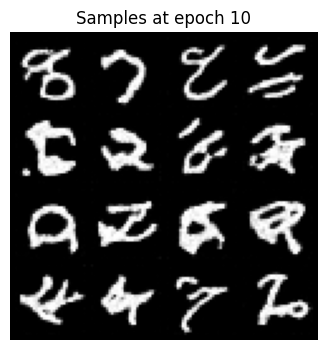

Total Epochs:  11%|█         | 11/100 [01:43<14:00,  9.44s/it]

Epoch 11 done. Avg Loss: 0.0651


Total Epochs:  12%|█▏        | 12/100 [01:53<13:47,  9.40s/it]

Epoch 12 done. Avg Loss: 0.0636


Total Epochs:  13%|█▎        | 13/100 [02:02<13:36,  9.39s/it]

Epoch 13 done. Avg Loss: 0.0625


Total Epochs:  14%|█▍        | 14/100 [02:11<13:25,  9.36s/it]

Epoch 14 done. Avg Loss: 0.0622


Total Epochs:  15%|█▌        | 15/100 [02:21<13:20,  9.42s/it]

Epoch 15 done. Avg Loss: 0.0605


Total Epochs:  16%|█▌        | 16/100 [02:30<13:07,  9.37s/it]

Epoch 16 done. Avg Loss: 0.0607


Total Epochs:  17%|█▋        | 17/100 [02:39<12:54,  9.34s/it]

Epoch 17 done. Avg Loss: 0.0590


Total Epochs:  18%|█▊        | 18/100 [02:49<12:44,  9.32s/it]

Epoch 18 done. Avg Loss: 0.0591


Total Epochs:  19%|█▉        | 19/100 [02:58<12:30,  9.27s/it]

Epoch 19 done. Avg Loss: 0.0582


Epoch 20 done. Avg Loss: 0.0581


Sampling: 100%|██████████| 200/200 [00:00<00:00, 644.13it/s]


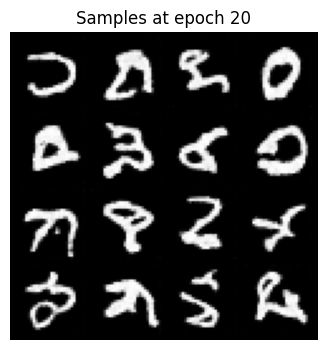

Total Epochs:  21%|██        | 21/100 [03:17<12:22,  9.40s/it]

Epoch 21 done. Avg Loss: 0.0571


Total Epochs:  22%|██▏       | 22/100 [03:26<12:09,  9.36s/it]

Epoch 22 done. Avg Loss: 0.0560


Total Epochs:  23%|██▎       | 23/100 [03:35<12:01,  9.36s/it]

Epoch 23 done. Avg Loss: 0.0562


Total Epochs:  24%|██▍       | 24/100 [03:45<11:51,  9.37s/it]

Epoch 24 done. Avg Loss: 0.0553


Total Epochs:  25%|██▌       | 25/100 [03:54<11:42,  9.37s/it]

Epoch 25 done. Avg Loss: 0.0555


Total Epochs:  26%|██▌       | 26/100 [04:03<11:30,  9.34s/it]

Epoch 26 done. Avg Loss: 0.0547


Total Epochs:  27%|██▋       | 27/100 [04:13<11:21,  9.33s/it]

Epoch 27 done. Avg Loss: 0.0545


Total Epochs:  28%|██▊       | 28/100 [04:22<11:11,  9.33s/it]

Epoch 28 done. Avg Loss: 0.0541


Total Epochs:  29%|██▉       | 29/100 [04:31<11:01,  9.32s/it]

Epoch 29 done. Avg Loss: 0.0546


Epoch 30 done. Avg Loss: 0.0541


Sampling: 100%|██████████| 200/200 [00:00<00:00, 636.68it/s]


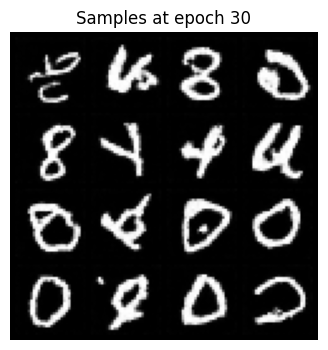

Total Epochs:  31%|███       | 31/100 [04:51<10:51,  9.44s/it]

Epoch 31 done. Avg Loss: 0.0537


Total Epochs:  32%|███▏      | 32/100 [05:00<10:42,  9.44s/it]

Epoch 32 done. Avg Loss: 0.0530


Total Epochs:  33%|███▎      | 33/100 [05:09<10:32,  9.45s/it]

Epoch 33 done. Avg Loss: 0.0525


Total Epochs:  34%|███▍      | 34/100 [05:19<10:24,  9.46s/it]

Epoch 34 done. Avg Loss: 0.0525


Total Epochs:  35%|███▌      | 35/100 [05:28<10:13,  9.45s/it]

Epoch 35 done. Avg Loss: 0.0526


Total Epochs:  36%|███▌      | 36/100 [05:38<10:02,  9.42s/it]

Epoch 36 done. Avg Loss: 0.0524


Total Epochs:  37%|███▋      | 37/100 [05:47<09:52,  9.40s/it]

Epoch 37 done. Avg Loss: 0.0524


Total Epochs:  38%|███▊      | 38/100 [05:57<09:44,  9.43s/it]

Epoch 38 done. Avg Loss: 0.0524


Total Epochs:  39%|███▉      | 39/100 [06:06<09:32,  9.39s/it]

Epoch 39 done. Avg Loss: 0.0518


Epoch 40 done. Avg Loss: 0.0516


Sampling: 100%|██████████| 200/200 [00:00<00:00, 628.56it/s]


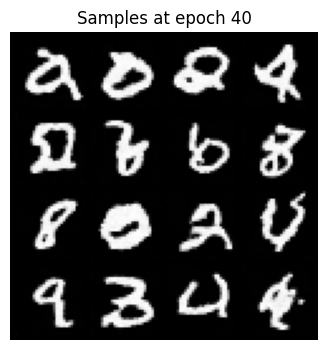

Total Epochs:  41%|████      | 41/100 [06:25<09:15,  9.41s/it]

Epoch 41 done. Avg Loss: 0.0511


Total Epochs:  42%|████▏     | 42/100 [06:34<09:03,  9.36s/it]

Epoch 42 done. Avg Loss: 0.0512


Total Epochs:  43%|████▎     | 43/100 [06:44<08:56,  9.42s/it]

Epoch 43 done. Avg Loss: 0.0513


Total Epochs:  44%|████▍     | 44/100 [06:53<08:46,  9.40s/it]

Epoch 44 done. Avg Loss: 0.0514


Total Epochs:  45%|████▌     | 45/100 [07:02<08:38,  9.43s/it]

Epoch 45 done. Avg Loss: 0.0515


Total Epochs:  46%|████▌     | 46/100 [07:12<08:30,  9.46s/it]

Epoch 46 done. Avg Loss: 0.0507


Total Epochs:  47%|████▋     | 47/100 [07:21<08:19,  9.43s/it]

Epoch 47 done. Avg Loss: 0.0509


Total Epochs:  48%|████▊     | 48/100 [07:31<08:09,  9.42s/it]

Epoch 48 done. Avg Loss: 0.0506


Total Epochs:  49%|████▉     | 49/100 [07:40<07:59,  9.41s/it]

Epoch 49 done. Avg Loss: 0.0502


Epoch 50 done. Avg Loss: 0.0502


Sampling: 100%|██████████| 200/200 [00:00<00:00, 625.50it/s]


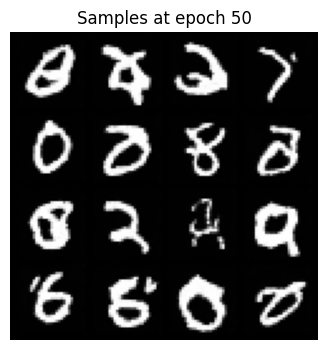

Total Epochs:  51%|█████     | 51/100 [07:59<07:44,  9.47s/it]

Epoch 51 done. Avg Loss: 0.0507


Total Epochs:  52%|█████▏    | 52/100 [08:09<07:32,  9.43s/it]

Epoch 52 done. Avg Loss: 0.0502


Total Epochs:  53%|█████▎    | 53/100 [08:18<07:23,  9.43s/it]

Epoch 53 done. Avg Loss: 0.0501


Total Epochs:  54%|█████▍    | 54/100 [08:27<07:09,  9.35s/it]

Epoch 54 done. Avg Loss: 0.0496


Total Epochs:  55%|█████▌    | 55/100 [08:36<07:00,  9.34s/it]

Epoch 55 done. Avg Loss: 0.0498


Total Epochs:  56%|█████▌    | 56/100 [08:46<06:48,  9.29s/it]

Epoch 56 done. Avg Loss: 0.0500


Total Epochs:  57%|█████▋    | 57/100 [08:55<06:38,  9.26s/it]

Epoch 57 done. Avg Loss: 0.0498


Total Epochs:  58%|█████▊    | 58/100 [09:04<06:28,  9.25s/it]

Epoch 58 done. Avg Loss: 0.0493


Total Epochs:  59%|█████▉    | 59/100 [09:13<06:18,  9.23s/it]

Epoch 59 done. Avg Loss: 0.0498


Epoch 60 done. Avg Loss: 0.0493


Sampling: 100%|██████████| 200/200 [00:00<00:00, 652.06it/s]


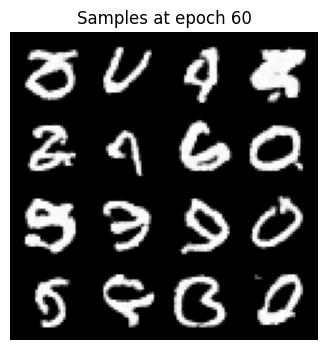

Total Epochs:  61%|██████    | 61/100 [09:32<06:01,  9.28s/it]

Epoch 61 done. Avg Loss: 0.0490


Total Epochs:  62%|██████▏   | 62/100 [09:41<05:52,  9.27s/it]

Epoch 62 done. Avg Loss: 0.0489


Total Epochs:  63%|██████▎   | 63/100 [09:50<05:40,  9.20s/it]

Epoch 63 done. Avg Loss: 0.0489


Total Epochs:  64%|██████▍   | 64/100 [09:59<05:29,  9.16s/it]

Epoch 64 done. Avg Loss: 0.0486


Total Epochs:  65%|██████▌   | 65/100 [10:08<05:21,  9.18s/it]

Epoch 65 done. Avg Loss: 0.0491


Total Epochs:  66%|██████▌   | 66/100 [10:18<05:11,  9.18s/it]

Epoch 66 done. Avg Loss: 0.0488


Total Epochs:  67%|██████▋   | 67/100 [10:27<05:03,  9.18s/it]

Epoch 67 done. Avg Loss: 0.0486


Total Epochs:  68%|██████▊   | 68/100 [10:36<04:53,  9.16s/it]

Epoch 68 done. Avg Loss: 0.0489


Total Epochs:  69%|██████▉   | 69/100 [10:45<04:43,  9.14s/it]

Epoch 69 done. Avg Loss: 0.0486


Epoch 70 done. Avg Loss: 0.0483


Sampling: 100%|██████████| 200/200 [00:00<00:00, 665.52it/s]


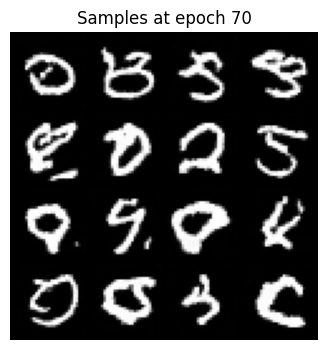

Total Epochs:  71%|███████   | 71/100 [11:04<04:28,  9.27s/it]

Epoch 71 done. Avg Loss: 0.0488


Total Epochs:  72%|███████▏  | 72/100 [11:13<04:18,  9.22s/it]

Epoch 72 done. Avg Loss: 0.0491


Total Epochs:  73%|███████▎  | 73/100 [11:22<04:09,  9.24s/it]

Epoch 73 done. Avg Loss: 0.0485


Total Epochs:  74%|███████▍  | 74/100 [11:31<03:59,  9.21s/it]

Epoch 74 done. Avg Loss: 0.0477


Total Epochs:  75%|███████▌  | 75/100 [11:41<03:49,  9.20s/it]

Epoch 75 done. Avg Loss: 0.0485


Total Epochs:  76%|███████▌  | 76/100 [11:50<03:40,  9.18s/it]

Epoch 76 done. Avg Loss: 0.0481


Total Epochs:  77%|███████▋  | 77/100 [11:59<03:30,  9.16s/it]

Epoch 77 done. Avg Loss: 0.0482


Total Epochs:  78%|███████▊  | 78/100 [12:08<03:23,  9.24s/it]

Epoch 78 done. Avg Loss: 0.0479


Total Epochs:  79%|███████▉  | 79/100 [12:18<03:14,  9.27s/it]

Epoch 79 done. Avg Loss: 0.0480


Epoch 80 done. Avg Loss: 0.0479


Sampling: 100%|██████████| 200/200 [00:00<00:00, 644.96it/s]


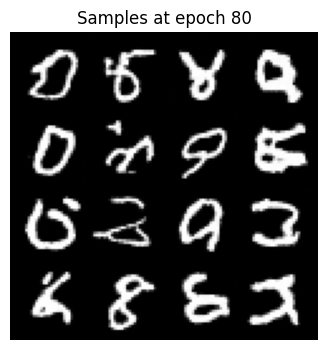

Total Epochs:  81%|████████  | 81/100 [12:36<02:57,  9.34s/it]

Epoch 81 done. Avg Loss: 0.0481


Total Epochs:  82%|████████▏ | 82/100 [12:46<02:47,  9.32s/it]

Epoch 82 done. Avg Loss: 0.0481


Total Epochs:  83%|████████▎ | 83/100 [12:55<02:38,  9.30s/it]

Epoch 83 done. Avg Loss: 0.0477


Total Epochs:  84%|████████▍ | 84/100 [13:04<02:28,  9.27s/it]

Epoch 84 done. Avg Loss: 0.0474


Total Epochs:  85%|████████▌ | 85/100 [13:13<02:19,  9.27s/it]

Epoch 85 done. Avg Loss: 0.0475


Total Epochs:  86%|████████▌ | 86/100 [13:23<02:09,  9.23s/it]

Epoch 86 done. Avg Loss: 0.0479


Total Epochs:  87%|████████▋ | 87/100 [13:32<01:59,  9.20s/it]

Epoch 87 done. Avg Loss: 0.0474


Total Epochs:  88%|████████▊ | 88/100 [13:41<01:50,  9.22s/it]

Epoch 88 done. Avg Loss: 0.0474


Total Epochs:  89%|████████▉ | 89/100 [13:50<01:41,  9.21s/it]

Epoch 89 done. Avg Loss: 0.0475


Epoch 90 done. Avg Loss: 0.0472


Sampling: 100%|██████████| 200/200 [00:00<00:00, 644.52it/s]


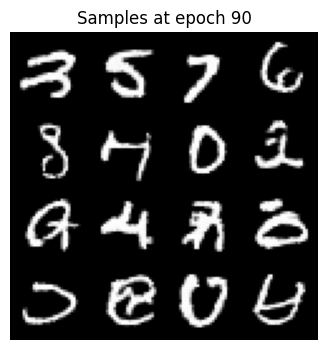

Total Epochs:  91%|█████████ | 91/100 [14:09<01:23,  9.33s/it]

Epoch 91 done. Avg Loss: 0.0476


Total Epochs:  92%|█████████▏| 92/100 [14:19<01:14,  9.36s/it]

Epoch 92 done. Avg Loss: 0.0477


Total Epochs:  93%|█████████▎| 93/100 [14:28<01:05,  9.34s/it]

Epoch 93 done. Avg Loss: 0.0474


Total Epochs:  94%|█████████▍| 94/100 [14:37<00:55,  9.25s/it]

Epoch 94 done. Avg Loss: 0.0473


Total Epochs:  95%|█████████▌| 95/100 [14:46<00:46,  9.26s/it]

Epoch 95 done. Avg Loss: 0.0469


Total Epochs:  96%|█████████▌| 96/100 [14:55<00:36,  9.21s/it]

Epoch 96 done. Avg Loss: 0.0472


Total Epochs:  97%|█████████▋| 97/100 [15:04<00:27,  9.18s/it]

Epoch 97 done. Avg Loss: 0.0470


Total Epochs:  98%|█████████▊| 98/100 [15:14<00:18,  9.19s/it]

Epoch 98 done. Avg Loss: 0.0473


Total Epochs:  99%|█████████▉| 99/100 [15:23<00:09,  9.19s/it]

Epoch 99 done. Avg Loss: 0.0475


Epoch 100 done. Avg Loss: 0.0471


Sampling: 100%|██████████| 200/200 [00:00<00:00, 676.54it/s]


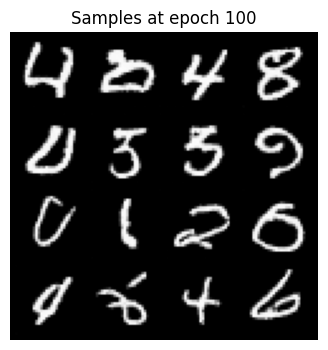

Total Epochs: 100%|██████████| 100/100 [15:32<00:00,  9.33s/it]

Training complete!


In [2]:
train_mnist_diffusion(
    lr=1e-3,
    batch_size=1024,  
    epochs=100,      
    timesteps=200,  
    model_base_dim=16, 
    dim_mults=[2, 4],  
    num_res_blocks_encoder=1, 
    num_res_blocks_decoder=1, 
    num_res_blocks_mid=1,     
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_freq=100,     
    show_every=10,    
    n_samples=16,
)

UNet model has 1,498,785 trainable parameters.


Total Epochs:   1%|          | 1/100 [00:19<32:20, 19.60s/it]

Epoch 1 done. Avg Loss: 0.1926


Total Epochs:   2%|▏         | 2/100 [00:38<31:28, 19.27s/it]

Epoch 2 done. Avg Loss: 0.0752


Total Epochs:   3%|▎         | 3/100 [00:57<30:58, 19.16s/it]

Epoch 3 done. Avg Loss: 0.0645


Total Epochs:   4%|▍         | 4/100 [01:17<31:13, 19.52s/it]

Epoch 4 done. Avg Loss: 0.0568


Total Epochs:   5%|▌         | 5/100 [01:35<29:58, 18.93s/it]

Epoch 5 done. Avg Loss: 0.0529


Total Epochs:   6%|▌         | 6/100 [01:53<29:09, 18.61s/it]

Epoch 6 done. Avg Loss: 0.0505


Total Epochs:   7%|▋         | 7/100 [02:12<29:02, 18.74s/it]

Epoch 7 done. Avg Loss: 0.0486


Total Epochs:   8%|▊         | 8/100 [02:32<29:20, 19.13s/it]

Epoch 8 done. Avg Loss: 0.0464


Total Epochs:   9%|▉         | 9/100 [02:51<29:05, 19.19s/it]

Epoch 9 done. Avg Loss: 0.0458


Epoch 10 done. Avg Loss: 0.0443


Sampling: 100%|██████████| 400/400 [00:00<00:00, 443.37it/s]


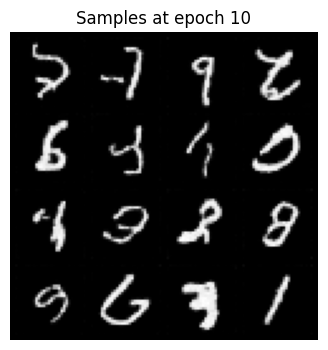

Total Epochs:  11%|█         | 11/100 [03:29<28:09, 18.98s/it]

Epoch 11 done. Avg Loss: 0.0439


Total Epochs:  12%|█▏        | 12/100 [03:48<27:59, 19.09s/it]

Epoch 12 done. Avg Loss: 0.0428


Total Epochs:  13%|█▎        | 13/100 [04:07<27:18, 18.84s/it]

Epoch 13 done. Avg Loss: 0.0421


Total Epochs:  14%|█▍        | 14/100 [04:25<26:58, 18.82s/it]

Epoch 14 done. Avg Loss: 0.0419


Total Epochs:  15%|█▌        | 15/100 [04:43<26:14, 18.52s/it]

Epoch 15 done. Avg Loss: 0.0411


Total Epochs:  16%|█▌        | 16/100 [05:01<25:45, 18.40s/it]

Epoch 16 done. Avg Loss: 0.0406


Total Epochs:  17%|█▋        | 17/100 [05:19<25:03, 18.11s/it]

Epoch 17 done. Avg Loss: 0.0406


Total Epochs:  18%|█▊        | 18/100 [05:37<24:49, 18.17s/it]

Epoch 18 done. Avg Loss: 0.0404


Total Epochs:  19%|█▉        | 19/100 [05:55<24:35, 18.22s/it]

Epoch 19 done. Avg Loss: 0.0397


Epoch 20 done. Avg Loss: 0.0402


Sampling: 100%|██████████| 400/400 [00:00<00:00, 441.90it/s]


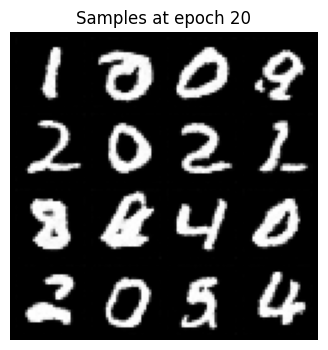

Total Epochs:  21%|██        | 21/100 [06:32<24:01, 18.25s/it]

Epoch 21 done. Avg Loss: 0.0389


Total Epochs:  22%|██▏       | 22/100 [06:50<23:37, 18.17s/it]

Epoch 22 done. Avg Loss: 0.0385


Total Epochs:  23%|██▎       | 23/100 [07:08<23:17, 18.14s/it]

Epoch 23 done. Avg Loss: 0.0387


Total Epochs:  24%|██▍       | 24/100 [07:26<22:43, 17.95s/it]

Epoch 24 done. Avg Loss: 0.0388


Total Epochs:  25%|██▌       | 25/100 [07:44<22:33, 18.05s/it]

Epoch 25 done. Avg Loss: 0.0381


Total Epochs:  26%|██▌       | 26/100 [08:03<22:29, 18.24s/it]

Epoch 26 done. Avg Loss: 0.0379


Total Epochs:  27%|██▋       | 27/100 [08:21<22:12, 18.25s/it]

Epoch 27 done. Avg Loss: 0.0377


Total Epochs:  28%|██▊       | 28/100 [08:40<22:07, 18.44s/it]

Epoch 28 done. Avg Loss: 0.0375


Total Epochs:  29%|██▉       | 29/100 [08:59<22:01, 18.62s/it]

Epoch 29 done. Avg Loss: 0.0374


Epoch 30 done. Avg Loss: 0.0375


Sampling: 100%|██████████| 400/400 [00:00<00:00, 437.85it/s]


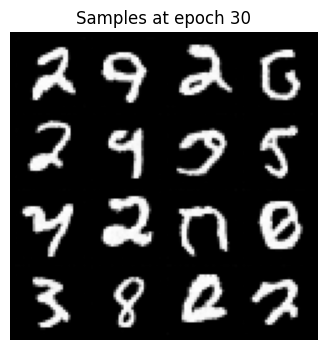

Total Epochs:  31%|███       | 31/100 [09:37<21:37, 18.80s/it]

Epoch 31 done. Avg Loss: 0.0370


Total Epochs:  32%|███▏      | 32/100 [09:55<21:00, 18.54s/it]

Epoch 32 done. Avg Loss: 0.0371


Total Epochs:  33%|███▎      | 33/100 [10:13<20:30, 18.36s/it]

Epoch 33 done. Avg Loss: 0.0368


Total Epochs:  34%|███▍      | 34/100 [10:30<20:00, 18.19s/it]

Epoch 34 done. Avg Loss: 0.0367


Total Epochs:  35%|███▌      | 35/100 [10:48<19:24, 17.91s/it]

Epoch 35 done. Avg Loss: 0.0369


Total Epochs:  36%|███▌      | 36/100 [11:07<19:28, 18.26s/it]

Epoch 36 done. Avg Loss: 0.0364


Total Epochs:  37%|███▋      | 37/100 [11:27<19:39, 18.73s/it]

Epoch 37 done. Avg Loss: 0.0366


Total Epochs:  38%|███▊      | 38/100 [11:47<19:44, 19.11s/it]

Epoch 38 done. Avg Loss: 0.0365


Total Epochs:  39%|███▉      | 39/100 [12:07<19:50, 19.51s/it]

Epoch 39 done. Avg Loss: 0.0363


Epoch 40 done. Avg Loss: 0.0364


Sampling: 100%|██████████| 400/400 [00:00<00:00, 415.36it/s]


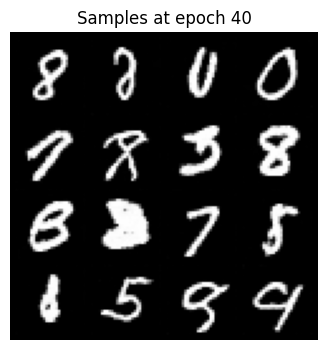

Total Epochs:  41%|████      | 41/100 [12:48<19:43, 20.07s/it]

Epoch 41 done. Avg Loss: 0.0360


Total Epochs:  42%|████▏     | 42/100 [13:09<19:28, 20.15s/it]

Epoch 42 done. Avg Loss: 0.0357


Total Epochs:  43%|████▎     | 43/100 [13:29<19:09, 20.16s/it]

Epoch 43 done. Avg Loss: 0.0360


Total Epochs:  44%|████▍     | 44/100 [13:49<18:50, 20.19s/it]

Epoch 44 done. Avg Loss: 0.0356


Total Epochs:  45%|████▌     | 45/100 [14:09<18:30, 20.19s/it]

Epoch 45 done. Avg Loss: 0.0355


Total Epochs:  46%|████▌     | 46/100 [14:30<18:10, 20.20s/it]

Epoch 46 done. Avg Loss: 0.0358


Total Epochs:  47%|████▋     | 47/100 [14:50<17:48, 20.17s/it]

Epoch 47 done. Avg Loss: 0.0357


Total Epochs:  48%|████▊     | 48/100 [15:10<17:26, 20.13s/it]

Epoch 48 done. Avg Loss: 0.0354


Total Epochs:  49%|████▉     | 49/100 [15:30<17:07, 20.15s/it]

Epoch 49 done. Avg Loss: 0.0354


Epoch 50 done. Avg Loss: 0.0354


Sampling: 100%|██████████| 400/400 [00:00<00:00, 410.65it/s]


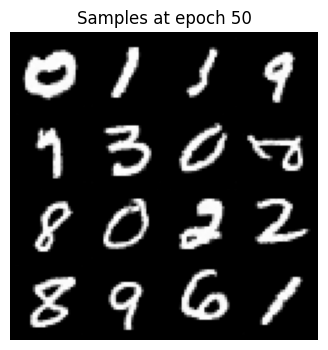

Total Epochs:  51%|█████     | 51/100 [16:11<16:36, 20.34s/it]

Epoch 51 done. Avg Loss: 0.0353


Total Epochs:  52%|█████▏    | 52/100 [16:31<16:13, 20.28s/it]

Epoch 52 done. Avg Loss: 0.0354


Total Epochs:  53%|█████▎    | 53/100 [16:51<15:50, 20.22s/it]

Epoch 53 done. Avg Loss: 0.0350


Total Epochs:  54%|█████▍    | 54/100 [17:12<15:29, 20.21s/it]

Epoch 54 done. Avg Loss: 0.0352


Total Epochs:  55%|█████▌    | 55/100 [17:32<15:07, 20.18s/it]

Epoch 55 done. Avg Loss: 0.0353


Total Epochs:  56%|█████▌    | 56/100 [17:52<14:47, 20.16s/it]

Epoch 56 done. Avg Loss: 0.0352


Total Epochs:  57%|█████▋    | 57/100 [18:12<14:27, 20.18s/it]

Epoch 57 done. Avg Loss: 0.0351


Total Epochs:  58%|█████▊    | 58/100 [18:32<14:07, 20.17s/it]

Epoch 58 done. Avg Loss: 0.0346


Total Epochs:  59%|█████▉    | 59/100 [18:52<13:47, 20.19s/it]

Epoch 59 done. Avg Loss: 0.0352


Epoch 60 done. Avg Loss: 0.0351


Sampling: 100%|██████████| 400/400 [00:00<00:00, 413.14it/s]


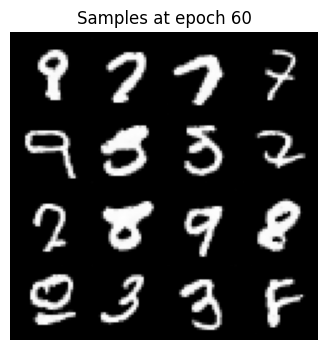

Total Epochs:  61%|██████    | 61/100 [19:34<13:15, 20.39s/it]

Epoch 61 done. Avg Loss: 0.0350


Total Epochs:  62%|██████▏   | 62/100 [19:54<12:52, 20.32s/it]

Epoch 62 done. Avg Loss: 0.0346


Total Epochs:  63%|██████▎   | 63/100 [20:14<12:30, 20.28s/it]

Epoch 63 done. Avg Loss: 0.0345


Total Epochs:  64%|██████▍   | 64/100 [20:34<12:07, 20.22s/it]

Epoch 64 done. Avg Loss: 0.0346


Total Epochs:  65%|██████▌   | 65/100 [20:54<11:46, 20.19s/it]

Epoch 65 done. Avg Loss: 0.0345


Total Epochs:  66%|██████▌   | 66/100 [21:14<11:26, 20.19s/it]

Epoch 66 done. Avg Loss: 0.0344


Total Epochs:  67%|██████▋   | 67/100 [21:34<11:04, 20.14s/it]

Epoch 67 done. Avg Loss: 0.0346


Total Epochs:  68%|██████▊   | 68/100 [21:55<10:45, 20.17s/it]

Epoch 68 done. Avg Loss: 0.0344


Total Epochs:  69%|██████▉   | 69/100 [22:15<10:24, 20.15s/it]

Epoch 69 done. Avg Loss: 0.0343


Epoch 70 done. Avg Loss: 0.0349


Sampling: 100%|██████████| 400/400 [00:00<00:00, 411.83it/s]


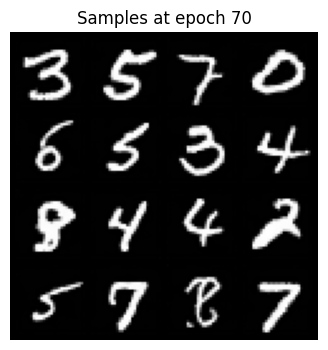

Total Epochs:  71%|███████   | 71/100 [22:56<09:50, 20.36s/it]

Epoch 71 done. Avg Loss: 0.0345


Total Epochs:  72%|███████▏  | 72/100 [23:16<09:27, 20.27s/it]

Epoch 72 done. Avg Loss: 0.0346


Total Epochs:  73%|███████▎  | 73/100 [23:36<09:05, 20.21s/it]

Epoch 73 done. Avg Loss: 0.0345


Total Epochs:  74%|███████▍  | 74/100 [23:56<08:45, 20.20s/it]

Epoch 74 done. Avg Loss: 0.0344


Total Epochs:  75%|███████▌  | 75/100 [24:16<08:24, 20.17s/it]

Epoch 75 done. Avg Loss: 0.0340


Total Epochs:  76%|███████▌  | 76/100 [24:37<08:03, 20.17s/it]

Epoch 76 done. Avg Loss: 0.0343


Total Epochs:  77%|███████▋  | 77/100 [24:57<07:43, 20.14s/it]

Epoch 77 done. Avg Loss: 0.0343


Total Epochs:  78%|███████▊  | 78/100 [25:17<07:22, 20.11s/it]

Epoch 78 done. Avg Loss: 0.0342


Total Epochs:  79%|███████▉  | 79/100 [25:37<07:02, 20.12s/it]

Epoch 79 done. Avg Loss: 0.0343


Epoch 80 done. Avg Loss: 0.0340


Sampling: 100%|██████████| 400/400 [00:00<00:00, 414.64it/s]


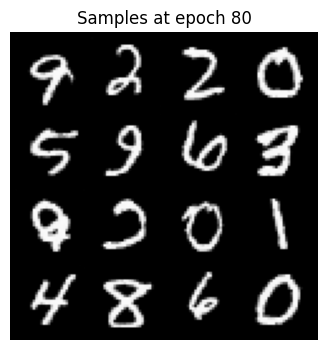

Total Epochs:  81%|████████  | 81/100 [26:18<06:26, 20.34s/it]

Epoch 81 done. Avg Loss: 0.0339


Total Epochs:  82%|████████▏ | 82/100 [26:38<06:05, 20.30s/it]

Epoch 82 done. Avg Loss: 0.0343


Total Epochs:  83%|████████▎ | 83/100 [26:59<05:44, 20.25s/it]

Epoch 83 done. Avg Loss: 0.0338


Total Epochs:  84%|████████▍ | 84/100 [27:19<05:23, 20.24s/it]

Epoch 84 done. Avg Loss: 0.0340


Total Epochs:  85%|████████▌ | 85/100 [27:39<05:03, 20.23s/it]

Epoch 85 done. Avg Loss: 0.0341


Total Epochs:  86%|████████▌ | 86/100 [27:59<04:42, 20.20s/it]

Epoch 86 done. Avg Loss: 0.0343


Total Epochs:  87%|████████▋ | 87/100 [28:19<04:22, 20.22s/it]

Epoch 87 done. Avg Loss: 0.0342


Total Epochs:  88%|████████▊ | 88/100 [28:40<04:02, 20.20s/it]

Epoch 88 done. Avg Loss: 0.0339


Total Epochs:  89%|████████▉ | 89/100 [29:00<03:42, 20.21s/it]

Epoch 89 done. Avg Loss: 0.0340


Epoch 90 done. Avg Loss: 0.0336


Sampling: 100%|██████████| 400/400 [00:00<00:00, 413.28it/s]


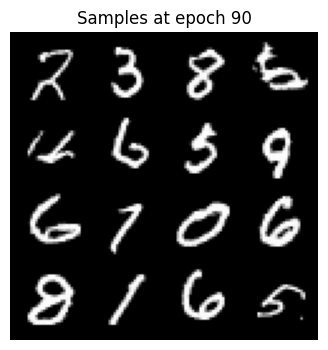

Total Epochs:  91%|█████████ | 91/100 [29:41<03:03, 20.42s/it]

Epoch 91 done. Avg Loss: 0.0339


Total Epochs:  92%|█████████▏| 92/100 [30:01<02:42, 20.34s/it]

Epoch 92 done. Avg Loss: 0.0340


Total Epochs:  93%|█████████▎| 93/100 [30:22<02:22, 20.30s/it]

Epoch 93 done. Avg Loss: 0.0334


Total Epochs:  94%|█████████▍| 94/100 [30:42<02:01, 20.25s/it]

Epoch 94 done. Avg Loss: 0.0340


Total Epochs:  95%|█████████▌| 95/100 [31:02<01:40, 20.19s/it]

Epoch 95 done. Avg Loss: 0.0337


Total Epochs:  96%|█████████▌| 96/100 [31:22<01:20, 20.20s/it]

Epoch 96 done. Avg Loss: 0.0337


Total Epochs:  97%|█████████▋| 97/100 [31:42<01:00, 20.16s/it]

Epoch 97 done. Avg Loss: 0.0341


Total Epochs:  98%|█████████▊| 98/100 [32:02<00:40, 20.17s/it]

Epoch 98 done. Avg Loss: 0.0339


Total Epochs:  99%|█████████▉| 99/100 [32:22<00:20, 20.15s/it]

Epoch 99 done. Avg Loss: 0.0335


Epoch 100 done. Avg Loss: 0.0337


Sampling: 100%|██████████| 400/400 [00:00<00:00, 413.90it/s]


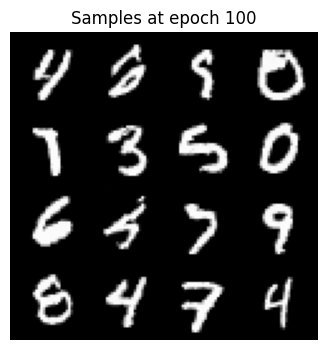

Total Epochs: 100%|██████████| 100/100 [32:43<00:00, 19.64s/it]

Training complete!


In [3]:
train_mnist_diffusion(
    lr=1e-3,
    batch_size=1024,  
    epochs=100,      
    timesteps=400,   
    model_base_dim=32, 
    dim_mults=[2, 4],  
    num_res_blocks_encoder=2, 
    num_res_blocks_decoder=2, 
    num_res_blocks_mid=1,     
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_freq=100,     
    show_every=10,    
    n_samples=16,
)

UNet model has 1,498,785 trainable parameters.


Total Epochs:   1%|          | 1/100 [00:20<33:18, 20.19s/it]

Epoch 1 done. Avg Loss: 0.1598


Total Epochs:   2%|▏         | 2/100 [00:40<32:38, 19.99s/it]

Epoch 2 done. Avg Loss: 0.0591


Total Epochs:   3%|▎         | 3/100 [00:59<32:15, 19.95s/it]

Epoch 3 done. Avg Loss: 0.0511


Total Epochs:   4%|▍         | 4/100 [01:20<32:08, 20.09s/it]

Epoch 4 done. Avg Loss: 0.0445


Total Epochs:   5%|▌         | 5/100 [01:39<31:24, 19.84s/it]

Epoch 5 done. Avg Loss: 0.0413


Total Epochs:   6%|▌         | 6/100 [01:58<30:49, 19.67s/it]

Epoch 6 done. Avg Loss: 0.0388


Total Epochs:   7%|▋         | 7/100 [02:18<30:19, 19.57s/it]

Epoch 7 done. Avg Loss: 0.0366


Total Epochs:   8%|▊         | 8/100 [02:37<29:54, 19.50s/it]

Epoch 8 done. Avg Loss: 0.0354


Total Epochs:   9%|▉         | 9/100 [02:57<29:31, 19.47s/it]

Epoch 9 done. Avg Loss: 0.0342


Epoch 10 done. Avg Loss: 0.0334


Sampling: 100%|██████████| 800/800 [00:01<00:00, 413.21it/s]


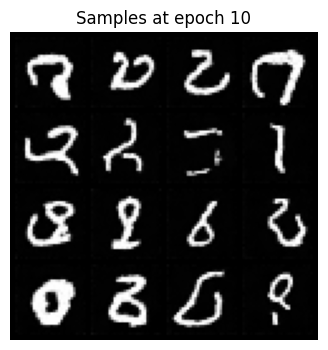

Total Epochs:  11%|█         | 11/100 [03:37<29:23, 19.81s/it]

Epoch 11 done. Avg Loss: 0.0324


Total Epochs:  12%|█▏        | 12/100 [03:57<28:51, 19.68s/it]

Epoch 12 done. Avg Loss: 0.0317


Total Epochs:  13%|█▎        | 13/100 [04:16<28:23, 19.58s/it]

Epoch 13 done. Avg Loss: 0.0317


Total Epochs:  14%|█▍        | 14/100 [04:35<27:58, 19.51s/it]

Epoch 14 done. Avg Loss: 0.0315


Total Epochs:  15%|█▌        | 15/100 [04:55<27:34, 19.46s/it]

Epoch 15 done. Avg Loss: 0.0306


Total Epochs:  16%|█▌        | 16/100 [05:14<27:10, 19.41s/it]

Epoch 16 done. Avg Loss: 0.0305


Total Epochs:  17%|█▋        | 17/100 [05:33<26:50, 19.40s/it]

Epoch 17 done. Avg Loss: 0.0298


Total Epochs:  18%|█▊        | 18/100 [05:53<26:27, 19.36s/it]

Epoch 18 done. Avg Loss: 0.0293


Total Epochs:  19%|█▉        | 19/100 [06:12<26:07, 19.35s/it]

Epoch 19 done. Avg Loss: 0.0294


Epoch 20 done. Avg Loss: 0.0292


Sampling: 100%|██████████| 800/800 [00:01<00:00, 412.75it/s]


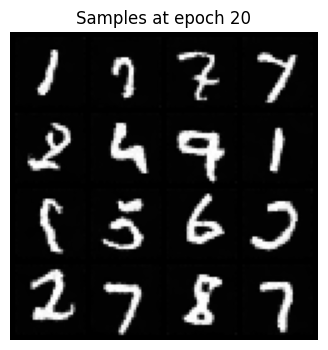

Total Epochs:  21%|██        | 21/100 [06:53<26:05, 19.81s/it]

Epoch 21 done. Avg Loss: 0.0287


Total Epochs:  22%|██▏       | 22/100 [07:12<25:33, 19.66s/it]

Epoch 22 done. Avg Loss: 0.0285


Total Epochs:  23%|██▎       | 23/100 [07:31<25:08, 19.59s/it]

Epoch 23 done. Avg Loss: 0.0285


Total Epochs:  24%|██▍       | 24/100 [07:51<24:41, 19.49s/it]

Epoch 24 done. Avg Loss: 0.0280


Total Epochs:  25%|██▌       | 25/100 [08:10<24:19, 19.46s/it]

Epoch 25 done. Avg Loss: 0.0277


Total Epochs:  26%|██▌       | 26/100 [08:29<23:57, 19.42s/it]

Epoch 26 done. Avg Loss: 0.0277


Total Epochs:  27%|██▋       | 27/100 [08:49<23:36, 19.40s/it]

Epoch 27 done. Avg Loss: 0.0278


Total Epochs:  28%|██▊       | 28/100 [09:08<23:16, 19.39s/it]

Epoch 28 done. Avg Loss: 0.0277


Total Epochs:  29%|██▉       | 29/100 [09:28<22:56, 19.38s/it]

Epoch 29 done. Avg Loss: 0.0271


Epoch 30 done. Avg Loss: 0.0275


Sampling: 100%|██████████| 800/800 [00:01<00:00, 410.10it/s]


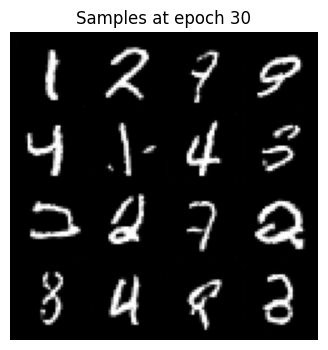

Total Epochs:  31%|███       | 31/100 [10:08<22:45, 19.79s/it]

Epoch 31 done. Avg Loss: 0.0273


Total Epochs:  32%|███▏      | 32/100 [10:28<22:17, 19.67s/it]

Epoch 32 done. Avg Loss: 0.0271


Total Epochs:  33%|███▎      | 33/100 [10:47<21:53, 19.61s/it]

Epoch 33 done. Avg Loss: 0.0270


Total Epochs:  34%|███▍      | 34/100 [11:06<21:30, 19.55s/it]

Epoch 34 done. Avg Loss: 0.0270


Total Epochs:  35%|███▌      | 35/100 [11:26<21:06, 19.49s/it]

Epoch 35 done. Avg Loss: 0.0264


Total Epochs:  36%|███▌      | 36/100 [11:45<20:45, 19.47s/it]

Epoch 36 done. Avg Loss: 0.0267


Total Epochs:  37%|███▋      | 37/100 [12:05<20:24, 19.43s/it]

Epoch 37 done. Avg Loss: 0.0265


Total Epochs:  38%|███▊      | 38/100 [12:24<20:02, 19.40s/it]

Epoch 38 done. Avg Loss: 0.0265


Total Epochs:  39%|███▉      | 39/100 [12:43<19:44, 19.41s/it]

Epoch 39 done. Avg Loss: 0.0264


Epoch 40 done. Avg Loss: 0.0261


Sampling: 100%|██████████| 800/800 [00:01<00:00, 412.93it/s]


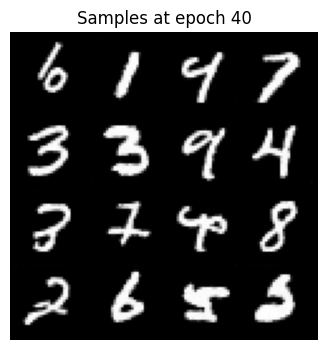

Total Epochs:  41%|████      | 41/100 [13:24<19:27, 19.79s/it]

Epoch 41 done. Avg Loss: 0.0262


Total Epochs:  42%|████▏     | 42/100 [13:43<19:00, 19.67s/it]

Epoch 42 done. Avg Loss: 0.0261


Total Epochs:  43%|████▎     | 43/100 [14:03<18:34, 19.56s/it]

Epoch 43 done. Avg Loss: 0.0258


Total Epochs:  44%|████▍     | 44/100 [14:22<18:12, 19.52s/it]

Epoch 44 done. Avg Loss: 0.0257


Total Epochs:  45%|████▌     | 45/100 [14:41<17:50, 19.47s/it]

Epoch 45 done. Avg Loss: 0.0259


Total Epochs:  46%|████▌     | 46/100 [15:01<17:28, 19.42s/it]

Epoch 46 done. Avg Loss: 0.0257


Total Epochs:  47%|████▋     | 47/100 [15:20<17:09, 19.42s/it]

Epoch 47 done. Avg Loss: 0.0258


Total Epochs:  48%|████▊     | 48/100 [15:40<16:55, 19.53s/it]

Epoch 48 done. Avg Loss: 0.0254


Total Epochs:  49%|████▉     | 49/100 [15:59<16:34, 19.50s/it]

Epoch 49 done. Avg Loss: 0.0259


Epoch 50 done. Avg Loss: 0.0259


Sampling: 100%|██████████| 800/800 [00:01<00:00, 409.27it/s]


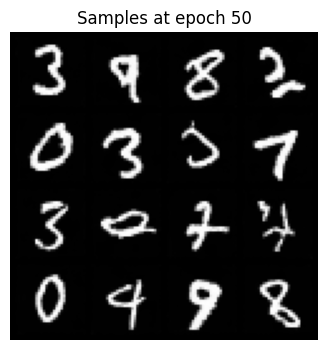

Total Epochs:  51%|█████     | 51/100 [16:41<16:19, 19.99s/it]

Epoch 51 done. Avg Loss: 0.0254


Total Epochs:  52%|█████▏    | 52/100 [17:01<16:03, 20.06s/it]

Epoch 52 done. Avg Loss: 0.0254


Total Epochs:  53%|█████▎    | 53/100 [17:21<15:44, 20.10s/it]

Epoch 53 done. Avg Loss: 0.0256


Total Epochs:  54%|█████▍    | 54/100 [17:41<15:27, 20.16s/it]

Epoch 54 done. Avg Loss: 0.0256


Total Epochs:  55%|█████▌    | 55/100 [18:02<15:07, 20.18s/it]

Epoch 55 done. Avg Loss: 0.0255


Total Epochs:  56%|█████▌    | 56/100 [18:22<14:52, 20.29s/it]

Epoch 56 done. Avg Loss: 0.0254


Total Epochs:  57%|█████▋    | 57/100 [18:42<14:31, 20.27s/it]

Epoch 57 done. Avg Loss: 0.0253


Total Epochs:  58%|█████▊    | 58/100 [19:03<14:12, 20.30s/it]

Epoch 58 done. Avg Loss: 0.0254


Total Epochs:  59%|█████▉    | 59/100 [19:23<13:49, 20.22s/it]

Epoch 59 done. Avg Loss: 0.0252


Epoch 60 done. Avg Loss: 0.0254


Sampling: 100%|██████████| 800/800 [00:01<00:00, 411.86it/s]


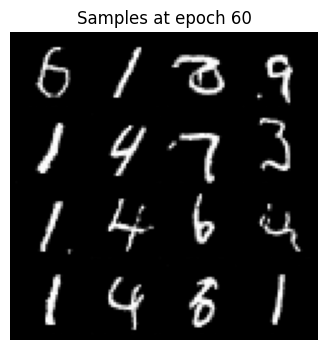

Total Epochs:  61%|██████    | 61/100 [20:05<13:26, 20.68s/it]

Epoch 61 done. Avg Loss: 0.0251


Total Epochs:  62%|██████▏   | 62/100 [20:26<13:00, 20.54s/it]

Epoch 62 done. Avg Loss: 0.0247


Total Epochs:  63%|██████▎   | 63/100 [20:45<12:30, 20.27s/it]

Epoch 63 done. Avg Loss: 0.0250


Total Epochs:  64%|██████▍   | 64/100 [21:04<11:55, 19.86s/it]

Epoch 64 done. Avg Loss: 0.0252


Total Epochs:  65%|██████▌   | 65/100 [21:23<11:28, 19.66s/it]

Epoch 65 done. Avg Loss: 0.0254


Total Epochs:  66%|██████▌   | 66/100 [21:43<11:04, 19.53s/it]

Epoch 66 done. Avg Loss: 0.0247


Total Epochs:  67%|██████▋   | 67/100 [22:02<10:44, 19.53s/it]

Epoch 67 done. Avg Loss: 0.0249


Total Epochs:  68%|██████▊   | 68/100 [22:22<10:25, 19.54s/it]

Epoch 68 done. Avg Loss: 0.0252


Total Epochs:  69%|██████▉   | 69/100 [22:41<10:02, 19.44s/it]

Epoch 69 done. Avg Loss: 0.0251


Epoch 70 done. Avg Loss: 0.0251


Sampling: 100%|██████████| 800/800 [00:01<00:00, 433.38it/s]


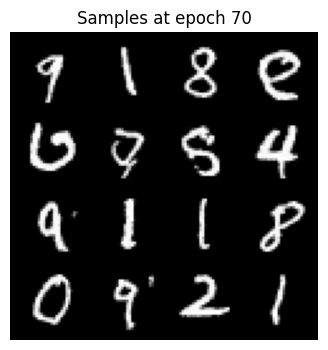

Total Epochs:  71%|███████   | 71/100 [23:23<09:44, 20.16s/it]

Epoch 71 done. Avg Loss: 0.0247


Total Epochs:  72%|███████▏  | 72/100 [23:43<09:22, 20.09s/it]

Epoch 72 done. Avg Loss: 0.0251


Total Epochs:  73%|███████▎  | 73/100 [24:03<09:02, 20.09s/it]

Epoch 73 done. Avg Loss: 0.0247


Total Epochs:  74%|███████▍  | 74/100 [24:22<08:37, 19.92s/it]

Epoch 74 done. Avg Loss: 0.0248


Total Epochs:  75%|███████▌  | 75/100 [24:42<08:17, 19.89s/it]

Epoch 75 done. Avg Loss: 0.0248


Total Epochs:  76%|███████▌  | 76/100 [25:02<07:54, 19.75s/it]

Epoch 76 done. Avg Loss: 0.0248


Total Epochs:  77%|███████▋  | 77/100 [25:22<07:36, 19.85s/it]

Epoch 77 done. Avg Loss: 0.0250


Total Epochs:  78%|███████▊  | 78/100 [25:41<07:14, 19.77s/it]

Epoch 78 done. Avg Loss: 0.0245


Total Epochs:  79%|███████▉  | 79/100 [26:01<06:53, 19.69s/it]

Epoch 79 done. Avg Loss: 0.0247


Epoch 80 done. Avg Loss: 0.0250


Sampling: 100%|██████████| 800/800 [00:01<00:00, 410.85it/s]


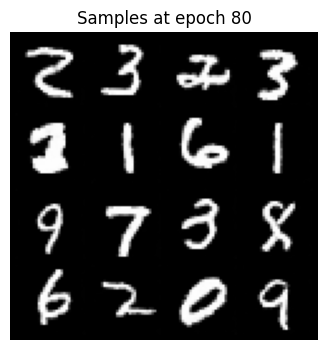

Total Epochs:  81%|████████  | 81/100 [26:42<06:20, 20.04s/it]

Epoch 81 done. Avg Loss: 0.0251


Total Epochs:  82%|████████▏ | 82/100 [27:01<05:57, 19.85s/it]

Epoch 82 done. Avg Loss: 0.0251


Total Epochs:  83%|████████▎ | 83/100 [27:21<05:35, 19.72s/it]

Epoch 83 done. Avg Loss: 0.0245


Total Epochs:  84%|████████▍ | 84/100 [27:40<05:14, 19.68s/it]

Epoch 84 done. Avg Loss: 0.0244


Total Epochs:  85%|████████▌ | 85/100 [28:00<04:54, 19.62s/it]

Epoch 85 done. Avg Loss: 0.0243


Total Epochs:  86%|████████▌ | 86/100 [28:19<04:34, 19.59s/it]

Epoch 86 done. Avg Loss: 0.0248


Total Epochs:  87%|████████▋ | 87/100 [28:39<04:14, 19.55s/it]

Epoch 87 done. Avg Loss: 0.0243


Total Epochs:  88%|████████▊ | 88/100 [28:58<03:54, 19.55s/it]

Epoch 88 done. Avg Loss: 0.0243


Total Epochs:  89%|████████▉ | 89/100 [29:18<03:34, 19.53s/it]

Epoch 89 done. Avg Loss: 0.0244


Epoch 90 done. Avg Loss: 0.0246


Sampling: 100%|██████████| 800/800 [00:01<00:00, 414.13it/s]


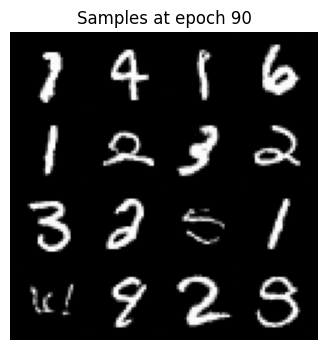

Total Epochs:  91%|█████████ | 91/100 [29:59<02:59, 19.95s/it]

Epoch 91 done. Avg Loss: 0.0246


Total Epochs:  92%|█████████▏| 92/100 [30:18<02:38, 19.82s/it]

Epoch 92 done. Avg Loss: 0.0246


Total Epochs:  93%|█████████▎| 93/100 [30:38<02:18, 19.74s/it]

Epoch 93 done. Avg Loss: 0.0245


Total Epochs:  94%|█████████▍| 94/100 [30:58<01:58, 19.71s/it]

Epoch 94 done. Avg Loss: 0.0245


Total Epochs:  95%|█████████▌| 95/100 [31:17<01:38, 19.71s/it]

Epoch 95 done. Avg Loss: 0.0241


Total Epochs:  96%|█████████▌| 96/100 [31:38<01:19, 19.89s/it]

Epoch 96 done. Avg Loss: 0.0243


Total Epochs:  97%|█████████▋| 97/100 [31:58<00:59, 19.98s/it]

Epoch 97 done. Avg Loss: 0.0240


Total Epochs:  98%|█████████▊| 98/100 [32:18<00:40, 20.06s/it]

Epoch 98 done. Avg Loss: 0.0242


Total Epochs:  99%|█████████▉| 99/100 [32:38<00:20, 20.13s/it]

Epoch 99 done. Avg Loss: 0.0244


Epoch 100 done. Avg Loss: 0.0245


Sampling: 100%|██████████| 800/800 [00:01<00:00, 413.48it/s]


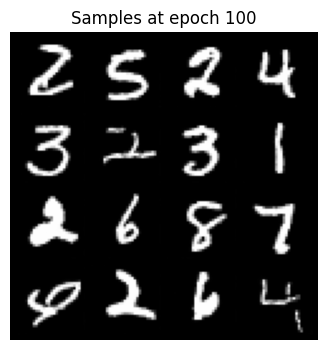

Total Epochs: 100%|██████████| 100/100 [33:00<00:00, 19.81s/it]

Training complete!


In [4]:
train_mnist_diffusion(
    lr=1e-3,
    batch_size=1024,  
    epochs=100,      
    timesteps=800,   
    model_base_dim=32, 
    dim_mults=[2, 4],  
    num_res_blocks_encoder=2, 
    num_res_blocks_decoder=2, 
    num_res_blocks_mid=1,     
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_freq=100,     
    show_every=10,    
    n_samples=16,
)

The generated images are sharper than those of VAEs! But diffusion takes significantly more time than VAEs since it has to make way more forward passes, but more forward passes, the better the generated image quality is.